---
# **LAB - video compression**
---

In [1]:
#@title ▶️ Base dir setup
import os, sys

# check if hosted (Google VM) or running on local server
if 'google.colab' in sys.modules:
  #@markdown Google Drive root folder - hosted by Google VM (adapt to your local paths)
  from google.colab import drive
  drive.mount('/content/drive', force_remount=False)
  base_dir = 'infoMM/' #@param {type: "string"}
  base_dir  = os.path.join('/content/drive/MyDrive/', base_dir)
  #!pip install pillow  --upgrade
else:
  #@markdown Path to local folder on PC (adapt to your local paths)
  base_dir  =  'C:/Users/eumir/Desktop/Università/Anno III/Semestre 1/Informazione Multimediale/VIDEO/'  #@param {type: "string"}

# dirs
wav_dir = '../AUDIO/Audio_IN/waw/'
mp3_dir = 'data/mp3/'
img_dir = '../IMMAGINI/Immagini_IN/'
vid_dir = 'VIDEO_IN/'
out_dir = 'VIDEO_OUT/'

# move to base_dir 
os.chdir(base_dir)
print("Current dir:", os.getcwd())

Current dir: C:\Users\eumir\Desktop\Università\Anno III\Semestre 1\Informazione Multimediale\VIDEO


In [2]:
import numpy as np
import cv2 as cv
from IPython.display import HTML
from base64 import b64encode
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
import time 
from sklearn.metrics import mean_squared_error

# Frame difference (DPCM)

Tot frames : 914



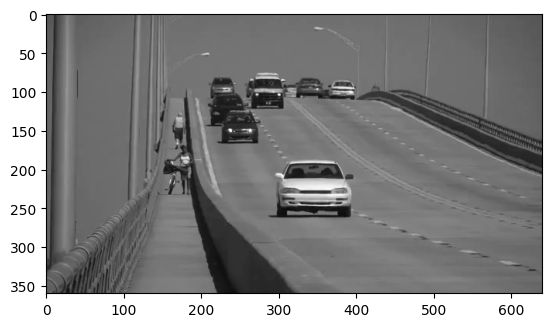

float32

Frame diff: frame[200] - frame[199]


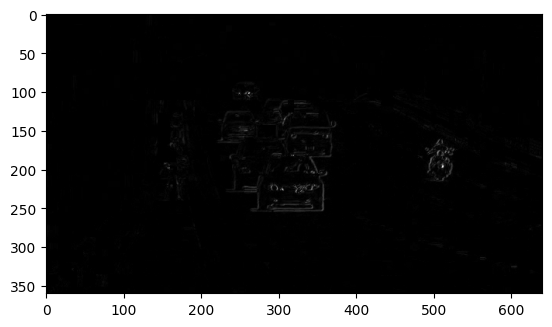


Frame diff: frame[400] - frame[399]


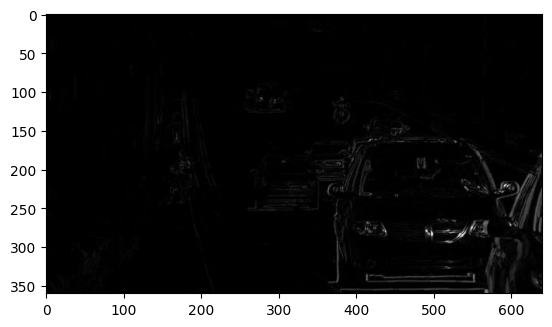


Frame diff: frame[600] - frame[599]


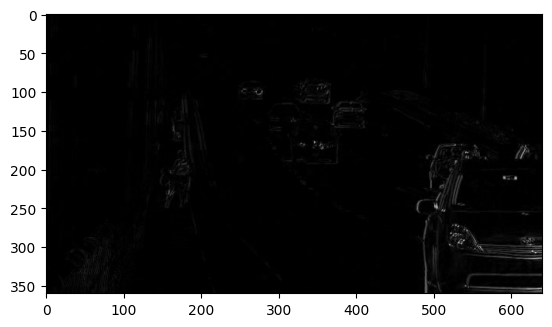


Frame diff: frame[800] - frame[799]


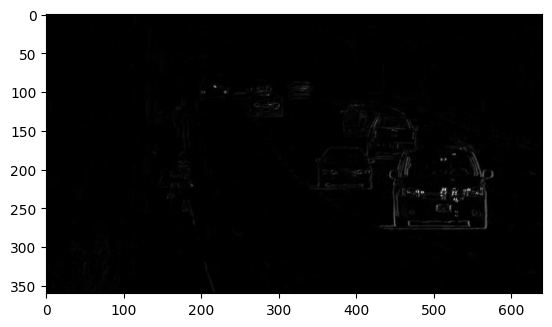

In [3]:
# video filename
filename = 'traffic.mp4'

# video capture
cap = cv.VideoCapture(vid_dir + filename)

# check if open
if not cap.isOpened():
  print("Cannot open file")
  exit()
    
# get total number of frames
totalFrames = cap.get(cv.CAP_PROP_FRAME_COUNT)
print('Tot frames : %d\n' %totalFrames)

# get the first frame 
succ, frame = cap.read()
assert succ, "Frame not found!"

# put in gray
gray_old = cv.cvtColor(frame, cv.COLOR_BGR2GRAY).astype('float32')

plt.imshow(gray_old, cmap='gray')
plt.show()

print((gray_old.dtype))

# get next frame
succ, frame = cap.read()

while succ:

  # make gray    
  gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY).astype('float32')

  # compute the difference
  diff = np.abs(gray - gray_old)
  gray_old = gray

  # show some 
  curIdx = int(cap.get(cv.CAP_PROP_POS_FRAMES)) # current frame index
  if curIdx % 200 == 0:
    print(f"\nFrame diff: frame[{curIdx}] - frame[{curIdx-1}]")
    plt.imshow(diff, cmap='gray')
    plt.show()
  
  # get next frame
  succ, frame = cap.read()

cap.release()


# Frame prediction (MAD)

Three Step Search
It is one of the earliest fast block matching algorithm. It runs as follows:

1. Start with search location at center
2. Set step size S = 4 and search parameter p = 7
3. Search 8 locations +/- S pixels around location (0,0) and the  location (0,0)
4. Pick among the 9 locations searched, the one with minimum cost function
5. Set the new search origin to the above picked location
6. Set the new step size as S = S/2
7. Repeat the search procedure until S = 1
8. The resulting location for S=1 is the one with minimum cost function and the macro block at this location is the best match.


There is a reduction in computation by a factor of 9 in this algorithm. For p=7, while ES evaluates cost for 225 macro-blocks, TSS evaluates only for 25 macro blocks.

### Utils

In [4]:
def getCenter(x, y, blockSize):
    """
    Determines center of a block with x, y as top left corner coordinates and blockSize as blockSize
    :return: x, y coordinates of center of a block
    """
    return (int(x + blockSize/2), int(y + blockSize/2))

def getAnchorSearchArea(x, y, anchor, blockSize, searchArea):
    """
    Returns image of anchor search area
    :param x, y: top left coordinate of macroblock in Current Frame
    :param anchor: I-Frame
    :param blockSize: size of block in pixels
    :param searchArea: size of search area in pixels
    :return: Image of anchor search area
    """
    h, w = anchor.shape
    cx, cy = getCenter(x, y, blockSize)

    sx = max(0, cx-int(blockSize/2)-searchArea) # ensure search area is in bounds
    sy = max(0, cy-int(blockSize/2)-searchArea) # and get top left corner of search area

    # slice anchor frame within bounds to produce anchor search area
    anchorSearch = anchor[sy:min(sy+searchArea*2+blockSize, h), sx:min(sx+searchArea*2+blockSize, w)]

    return anchorSearch, [sy, min(sy+searchArea*2+blockSize, h), sx, min(sx+searchArea*2+blockSize, w)]

def getBlockZone(p, aSearch, tBlock, blockSize):
    """
    Retrieves the block searched in the anchor search area to be compared with the macroblock tBlock in the current frame
    :param p: x,y coordinates of macroblock center from current frame
    :param aSearch: anchor search area image
    :param tBlock: macroblock from current frame
    :param blockSize: size of macroblock in pixels
    :return: macroblock from anchor
    """
    px, py = p # coordinates of macroblock center
    px, py = px-int(blockSize/2), py-int(blockSize/2) # get top left corner of macroblock
    px, py = max(0,px), max(0,py) # ensure macroblock is within bounds

    aBlock = aSearch[py:py+blockSize, px:px+blockSize] # retrive macroblock from anchor search area

    try:
        assert aBlock.shape == tBlock.shape # must be same shape

    except Exception as e:
        print(e)
        print(f"ERROR - ABLOCK SHAPE: {aBlock.shape} != TBLOCK SHAPE: {tBlock.shape}")

    return aBlock

def getMAD(tBlock, aBlock):
    """
    Returns Mean Absolute Difference between current frame macroblock (tBlock) and anchor frame macroblock (aBlock)
    """
    return np.sum(np.abs(np.subtract(tBlock, aBlock)))/(tBlock.shape[0]*tBlock.shape[1])

def getBestMatch(tBlock, aSearch, blockSize): 
    """
    Implemented 3 Step Search. Read about it here: https://en.wikipedia.org/wiki/Block-matching_algorithm#Three_Step_Search
    :param tBlock: macroblock from current frame
    :param aSearch: anchor search area
    :param blockSize: size of macroblock in pixels
    :return: macroblock from anchor search area with least MAD
    """
    step = 4
    ah, aw = aSearch.shape
    acy, acx = int(ah/2), int(aw/2) # get center of anchor search area

    minMAD = float("+inf")
    minP = None

    while step >= 1:
        p1 = (acx, acy)
        p2 = (acx+step, acy)
        p3 = (acx, acy+step)
        p4 = (acx+step, acy+step)
        p5 = (acx-step, acy)
        p6 = (acx, acy-step)
        p7 = (acx-step, acy-step)
        p8 = (acx+step, acy-step)
        p9 = (acx-step, acy+step)
        pointList = [p1,p2,p3,p4,p5,p6,p7,p8,p9] # retrieve 9 search points

        for p in range(len(pointList)):
            aBlock = getBlockZone(pointList[p], aSearch, tBlock, blockSize) # get anchor macroblock
            MAD = getMAD(tBlock, aBlock) # determine MAD
            if MAD < minMAD: # store point with minimum mAD
                minMAD = MAD
                minP = pointList[p]

        step = int(step/2)

    px, py = minP # center of anchor block with minimum MAD
    px, py = px - int(blockSize / 2), py - int(blockSize / 2) # get top left corner of minP
    px, py = max(0, px), max(0, py) # ensure minP is within bounds
    matchBlock = aSearch[py:py + blockSize, px:px + blockSize] # retrieve best macroblock from anchor search area

    return matchBlock, [py, py + blockSize, px, px + blockSize]

def blockSearchBody(anchor, target, blockSize, searchArea=7, verbose=False):
    """
    Facilitates the creation of a predicted frame based on the anchor and target frame
      
    Params:
      anchor     : I-Frame
      target     : Current Frame to create a P-Frame from
      blockSize  : size of macroBlock in pixels
      searchArea : size of searchArea extended from blockSize
    
    Return: 
      predicted  : predicted frame
    """

    h, w = anchor.shape        # orig dimensions in pixels
    image = cv.cvtColor(anchor, cv.COLOR_GRAY2RGB)  # for plotting purposes 
    b = blockSize
    b1 = b//2

    
    # resize frame to fit segmentation
    h, w = anchor.shape
    hSegments = int(h / blockSize)
    wSegments = int(w / blockSize)

    predicted = np.ones((h, w))*255
    bcount = 0
    for y in range(0, int(hSegments*blockSize), blockSize):
      for x in range(0, int(wSegments*blockSize), blockSize):
        bcount+=1

        #get current macroblock
        targetBlock = target[y:y+blockSize, x:x+blockSize] 

        #get anchor search area
        anchorSearchArea, [Y0, Y1, X0, X1] = getAnchorSearchArea(x, y, anchor, blockSize, searchArea) 

        #get best anchor macroblock
        anchorBlock, [y0, y1, x0, x1] = getBestMatch(targetBlock, anchorSearchArea, blockSize) 
        
        #add anchor block to predicted frame
        predicted[y:y+blockSize, x:x+blockSize] = anchorBlock 

        if verbose and (bcount % 50 == 0):
          print(f"\nBlock {bcount}")
          print(f"\nMB coords: x={x} y={y}")
          print(f"\nMB coords: x={x0} y={y0}")
          print("Anchor search area: ", anchorSearchArea.shape)
          print("Area coords: ", [[X0,Y0], [X1, Y1]])
          G = (0,255,0); R = (0,0,255); M = (255,0,255); Y = (0,255,255); W = (255,255,255)
          image = cv.rectangle(image, (X0, Y0), (X1, Y1), W, 2)            # search area
          image = cv.rectangle(image, (X0+x0, Y0+y0), (X0+x1, Y0+y1), G)  # MB predicted
          image = cv.rectangle(image, (x, y), (x+b, y+b), R)              # MB target
          image = cv.arrowedLine(image, (x+b1, y+b1), (X0+x0+b1, Y0+y0+b1), W)  # arrow from target 2 pred
          plt.imshow(image)
          plt.show()
    return predicted

def getResidualMetric(residualFrame):
  """Calculate residual metric from average of sum of 
     absolute residual values in residual frame
  """
  return np.sum(np.abs(residualFrame))/(residualFrame.shape[0]*residualFrame.shape[1])

def preprocess(anchor, target, blockSize):

  # Converts numpy image into from RGB to YCrCb color space
  anchorFrame = cv.cvtColor(anchor, cv.COLOR_RGB2YCrCb)[:, :, 0] # get luma component
  targetFrame = cv.cvtColor(target, cv.COLOR_RGB2YCrCb)[:, :, 0] # get luma component

  # resize frame to fit segmentation
  h, w = anchorFrame.shape
  hSegments = int(h / blockSize)
  wSegments = int(w / blockSize)
  totBlocks = int(hSegments * wSegments)

  print('******* ORIG *********')
  print(f"Height: {h}, Width: {w}")
  print(f"Segments: Height: {hSegments}, Width: {wSegments}")
  print(f"Total Blocks: {totBlocks}\n")

  anchorFrame = cv.resize(anchorFrame, (int(wSegments*blockSize), int(hSegments*blockSize)))
  targetFrame = cv.resize(targetFrame, (int(wSegments*blockSize), int(hSegments*blockSize)))
  print(f"Final shape of anchor frame: {anchorFrame.shape}")
  print(f"Final shape of target frame: {targetFrame.shape}")
  return (anchorFrame, targetFrame)

def get_frame_list(filename):
  # video capture
  cap = cv.VideoCapture(filename)

  # check if open
  if not cap.isOpened():
    print("Cannot open file")
    return None
      
  frames = []
  while cap.isOpened():
    # get next frame
    ret, frame = cap.read()
    # if frame is read correctly ret is True
    if not ret:
      break
    frames.append(cv.cvtColor(frame, cv.COLOR_BGR2RGB))
  cap.release()
  return np.array(frames)

******* ORIG *********
Height: 360, Width: 640
Segments: Height: 22, Width: 40
Total Blocks: 880

Final shape of anchor frame: (352, 640)
Final shape of target frame: (352, 640)


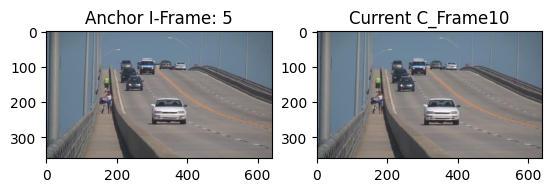

In [5]:
########## MAIN ########

verbose = True       # =True shows all processing details
refIdx = 5           # the ID of the reference frame
curIdx =  10         # the ID of the target frame
blockSize = 16       # the macroblock size

# Choose I-Frame and the current frame
frames = get_frame_list(vid_dir + filename) # load a list of frames
I_Frame = frames[refIdx]
C_Frame = frames[curIdx]

 

plt.subplot(1,2,1)
# show frames
plt.imshow(I_Frame)
plt.title('Anchor I-Frame: ' + str(refIdx))

plt.subplot(1,2,2)
plt.imshow(C_Frame)
plt.title('Current C_Frame' + str(curIdx))

# resize frame to fit segmentation
anchorFrame, targetFrame = preprocess(I_Frame, C_Frame, blockSize)


---------------   START ITERATION ON MBs   --------------


Block 50

MB coords: x=144 y=16

MB coords: x=11 y=3
Anchor search area:  (30, 30)
Area coords:  [[137, 9], [167, 39]]


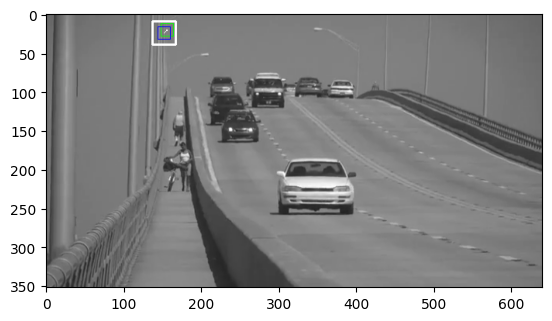


Block 100

MB coords: x=304 y=32

MB coords: x=3 y=3
Anchor search area:  (30, 30)
Area coords:  [[297, 25], [327, 55]]


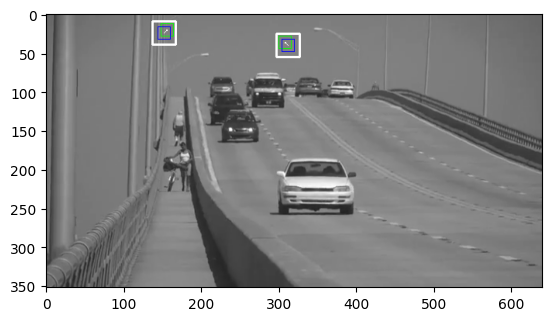


Block 150

MB coords: x=464 y=48

MB coords: x=6 y=7
Anchor search area:  (30, 30)
Area coords:  [[457, 41], [487, 71]]


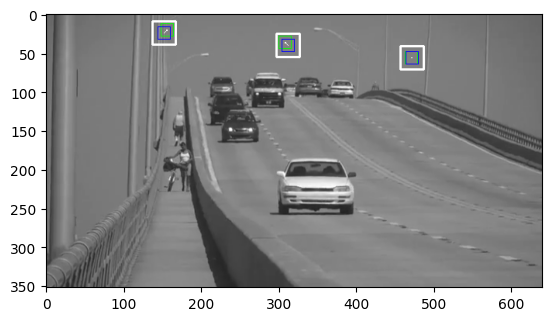


Block 200

MB coords: x=624 y=64

MB coords: x=7 y=3
Anchor search area:  (30, 23)
Area coords:  [[617, 57], [640, 87]]


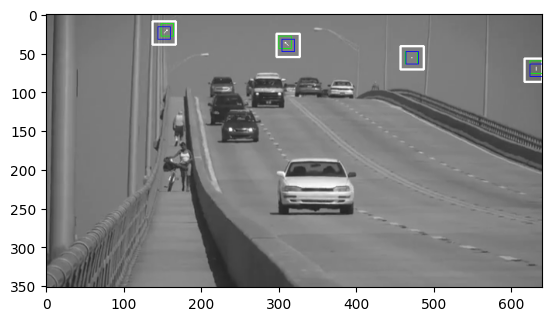


Block 250

MB coords: x=144 y=96

MB coords: x=11 y=3
Anchor search area:  (30, 30)
Area coords:  [[137, 89], [167, 119]]


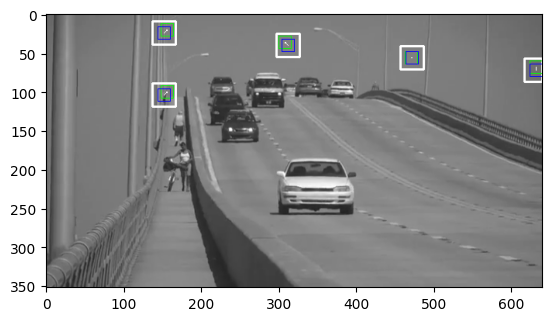


Block 300

MB coords: x=304 y=112

MB coords: x=3 y=7
Anchor search area:  (30, 30)
Area coords:  [[297, 105], [327, 135]]


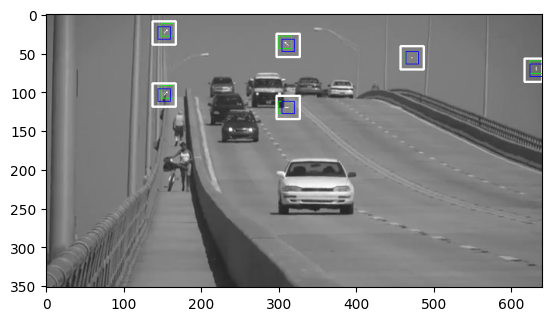


Block 350

MB coords: x=464 y=128

MB coords: x=7 y=9
Anchor search area:  (30, 30)
Area coords:  [[457, 121], [487, 151]]


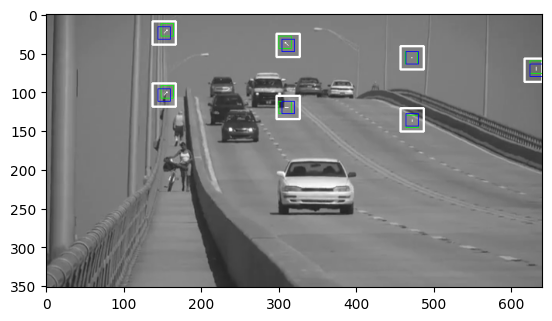


Block 400

MB coords: x=624 y=144

MB coords: x=7 y=11
Anchor search area:  (30, 23)
Area coords:  [[617, 137], [640, 167]]


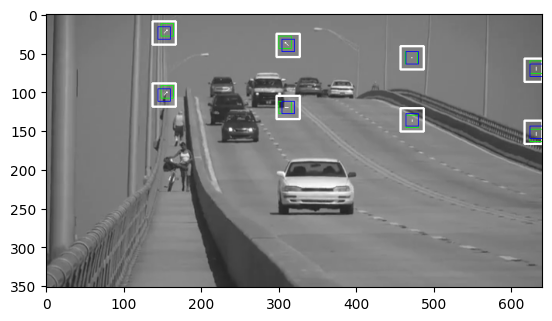


Block 450

MB coords: x=144 y=176

MB coords: x=6 y=8
Anchor search area:  (30, 30)
Area coords:  [[137, 169], [167, 199]]


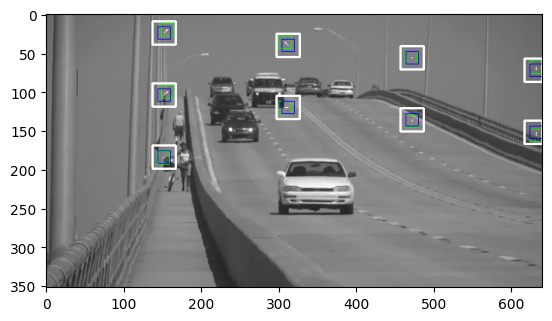


Block 500

MB coords: x=304 y=192

MB coords: x=11 y=11
Anchor search area:  (30, 30)
Area coords:  [[297, 185], [327, 215]]


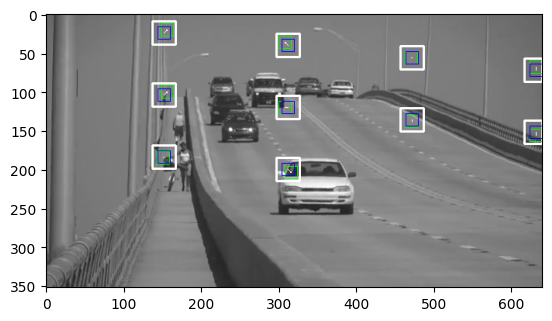


Block 550

MB coords: x=464 y=208

MB coords: x=6 y=7
Anchor search area:  (30, 30)
Area coords:  [[457, 201], [487, 231]]


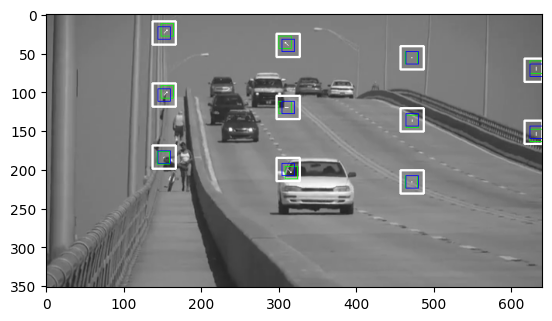


Block 600

MB coords: x=624 y=224

MB coords: x=7 y=7
Anchor search area:  (30, 23)
Area coords:  [[617, 217], [640, 247]]


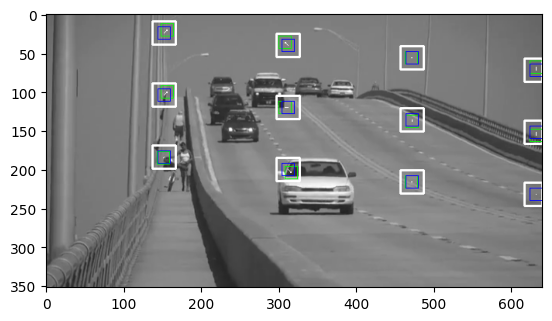


Block 650

MB coords: x=144 y=256

MB coords: x=6 y=6
Anchor search area:  (30, 30)
Area coords:  [[137, 249], [167, 279]]


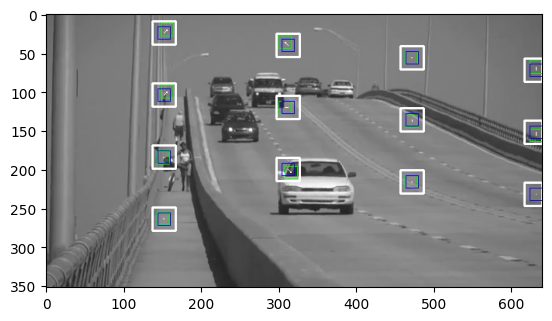


Block 700

MB coords: x=304 y=272

MB coords: x=7 y=7
Anchor search area:  (30, 30)
Area coords:  [[297, 265], [327, 295]]


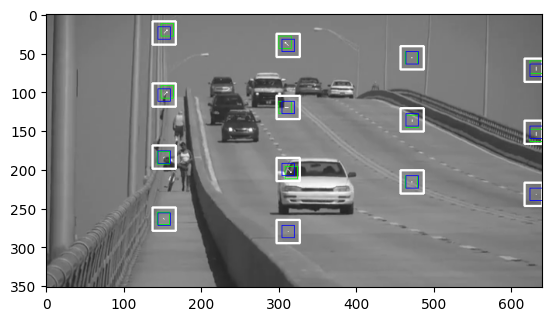


Block 750

MB coords: x=464 y=288

MB coords: x=7 y=7
Anchor search area:  (30, 30)
Area coords:  [[457, 281], [487, 311]]


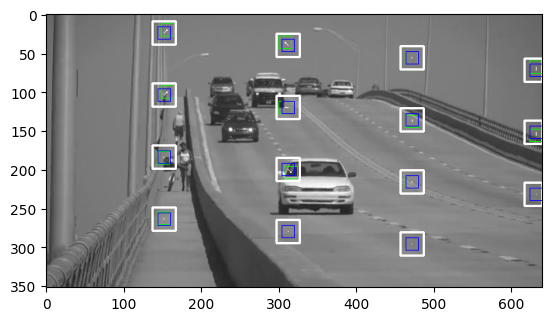


Block 800

MB coords: x=624 y=304

MB coords: x=7 y=7
Anchor search area:  (30, 23)
Area coords:  [[617, 297], [640, 327]]


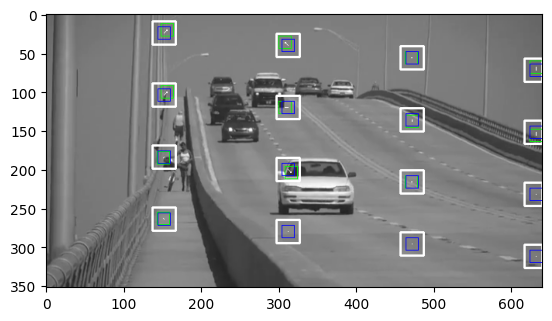


Block 850

MB coords: x=144 y=336

MB coords: x=3 y=0
Anchor search area:  (23, 30)
Area coords:  [[137, 329], [167, 352]]


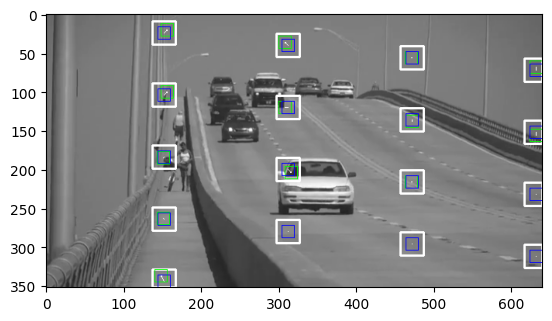

In [6]:
print('\n---------------   START ITERATION ON MBs   --------------\n')
predictedFrame = blockSearchBody(anchorFrame, targetFrame, blockSize, verbose=verbose)

# Create residual frame from target frame - predicted frame
residualFrame = np.subtract(targetFrame, predictedFrame)
naiveResidualFrame = np.subtract(anchorFrame, targetFrame)

# Reconstruct target frame from residual frame plus predicted frame
reconstructTargetFrame = np.add(residualFrame, predictedFrame)


---------------   STOP ITERATION ON MBs   --------------


Target frame


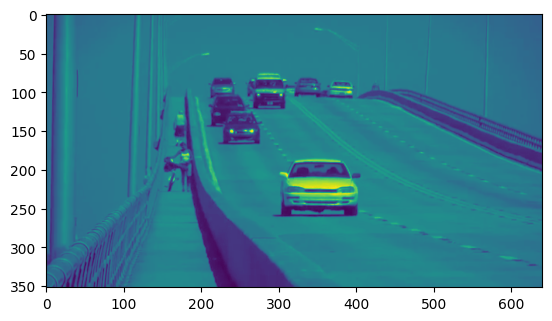


Predicted frame


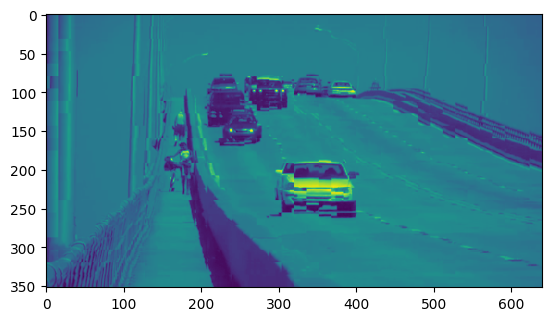


Residual frame


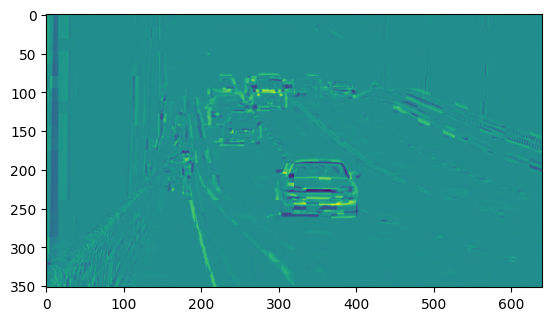

Residual Metric: 6.30
Naive Residual Metric: 72.91


In [7]:
print('\n---------------   STOP ITERATION ON MBs   --------------\n')

# show frames
print('\nTarget frame')
plt.imshow(targetFrame)
plt.show()
print('\nPredicted frame')
plt.imshow(predictedFrame)
plt.show()
print('\nResidual frame')
plt.imshow(residualFrame)
plt.show()

residualMetric = getResidualMetric(residualFrame)
naiveResidualMetric = getResidualMetric(naiveResidualFrame)

print(f"Residual Metric: {residualMetric:.2f}")
print(f"Naive Residual Metric: {naiveResidualMetric:.2f}")


**Exercise**

- create the function getMSE to compute the MSE between current frame macroblock (tBlock) and anchor frame macroblock (aBlock)

- modify the functions in Utils so that we can parametrically choose to use MAD or MSE